In [1]:
# drop_rate = 0.4
# warmup

In [2]:
import datetime
import gc
import glob
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import multiprocessing
import os
import pickle
import random
import time

from fastprogress import master_bar, progress_bar
from keras.preprocessing import text, sequence
import matplotlib.pyplot as plt
from nltk.tokenize.treebank import TreebankWordTokenizer
import numpy as np
import pandas as pd

import seaborn as sns
import shap
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset


%matplotlib inline
sns.set(style='ticks')
tqdm.pandas()

Using TensorFlow backend.


In [3]:
# https://github.com/ildoonet/pytorch-gradual-warmup-lr/blob/master/warmup_scheduler/scheduler.py

from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau


class GradualWarmupScheduler(_LRScheduler):
    """ Gradually warm-up(increasing) learning rate in optimizer.
    Proposed in 'Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour'.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        multiplier: target learning rate = base lr * multiplier
        total_epoch: target learning rate is reached at total_epoch, gradually
        after_scheduler: after target_epoch, use this scheduler(eg. ReduceLROnPlateau)
    """

    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        self.multiplier = multiplier
        if self.multiplier <= 1.:
            raise ValueError('multiplier should be greater than 1.')
        self.total_epoch = total_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        super().__init__(optimizer)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]

        return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

    def step_ReduceLROnPlateau(self, metrics, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch if epoch != 0 else 1  # ReduceLROnPlateau is called at the end of epoch, whereas others are called at beginning
        if self.last_epoch <= self.total_epoch:
            warmup_lr = [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
            for param_group, lr in zip(self.optimizer.param_groups, warmup_lr):
                param_group['lr'] = lr
        else:
            if epoch is None:
                self.after_scheduler.step(metrics, None)
            else:
                self.after_scheduler.step(metrics, epoch - self.total_epoch)

    def step(self, epoch=None, metrics=None):
        if type(self.after_scheduler) != ReduceLROnPlateau:
            if self.finished and self.after_scheduler:
                if epoch is None:
                    self.after_scheduler.step(None)
                else:
                    self.after_scheduler.step(epoch - self.total_epoch)
            else:
                return super(GradualWarmupScheduler, self).step(epoch)
        else:
            self.step_ReduceLROnPlateau(metrics, epoch)

In [4]:
def get_logger():
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    # handler1
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(asctime)s %(levelname)8s %(message)s"))
    # handler2
    handler2 = FileHandler(filename=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+".log")
    handler2.setFormatter(Formatter("%(asctime)s %(levelname)8s %(message)s"))
    # addHandler
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def seed_everything(seed=123):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def log_loss(y_true, y_pred, epsilon=1e-12):
    y_pred = np.clip(y_pred, epsilon, 1-epsilon)
    return -(np.log(y_pred) * y_true + np.log(1 - y_pred) * (1 - y_true))

class JigsawEvaluator:
    def __init__(self, y_true, y_identity, power=-5, overall_model_weight=0.25):
        self.y = (y_true >= 0.5).astype(int)
        self.y_i = (y_identity >= 0.5).astype(int)
        self.n_subgroups = self.y_i.shape[1]
        self.power = power
        self.overall_model_weight = overall_model_weight

    @staticmethod
    def _compute_auc(y_true, y_pred):
        try:
            return roc_auc_score(y_true, y_pred)
        except ValueError:
            return np.nan

    def _compute_subgroup_auc(self, i, y_pred):
        mask = self.y_i[:, i] == 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def _compute_bpsn_auc(self, i, y_pred):
        mask = self.y_i[:, i] + self.y == 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def _compute_bnsp_auc(self, i, y_pred):
        mask = self.y_i[:, i] + self.y != 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def compute_bias_metrics_for_model(self, y_pred):
        records = np.zeros((3, self.n_subgroups))
        for i in range(self.n_subgroups):
            records[0, i] = self._compute_subgroup_auc(i, y_pred)
            records[1, i] = self._compute_bpsn_auc(i, y_pred)
            records[2, i] = self._compute_bnsp_auc(i, y_pred)
        return records

    def _calculate_overall_auc(self, y_pred):
        return roc_auc_score(self.y, y_pred)

    def _power_mean(self, array):
        total = sum(np.power(array, self.power))
        return np.power(total / len(array), 1 / self.power)

    def get_final_metric(self, y_pred):
        bias_metrics = self.compute_bias_metrics_for_model(y_pred)
        bias_score = np.average([
            self._power_mean(bias_metrics[0]),
            self._power_mean(bias_metrics[1]),
            self._power_mean(bias_metrics[2])
        ])
        overall_score = self.overall_model_weight * self._calculate_overall_auc(y_pred)
        bias_score = (1 - self.overall_model_weight) * bias_score
        return overall_score + bias_score, bias_metrics[0], bias_metrics[1], bias_metrics[2]

In [5]:
# logger
logger = get_logger()

# parameters
n_workers = 4
n_splits = 5
seed = 777
seed_everything(seed)

maxlen = 300
max_features = 410047

batch_size = 512
lr = 0.001
epochs = 10
n_fold = 1
drop_rate = 0.4 # default=0.3

# path
CRAWL_EMBEDDING_PATH = '../input/pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl'
GLOVE_EMBEDDING_PATH = '../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl'
# GOOGLE_EMBEDDING_PATH = '../input/quoratextemb/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin'
# WIKI_EMBEDDING_PATH = '../input/quoratextemb/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'

# constants
target = 'target'
aux_target = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness'
]

### loading

In [6]:
train = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')
print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')
train.head(3)

train shape: (1804874, 45)
test shape: (97320, 2)


,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.0,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.0,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.0,This is such an urgent design problem; kudos t...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4


In [7]:
test.head(3)

,id,comment_text
0,7000000,Jeff Sessions is another one of Trump's Orwell...
1,7000001,I actually inspected the infrastructure on Gra...
2,7000002,No it won't . That's just wishful thinking on ...


In [8]:
# Overall
weights = np.ones((len(train),)) / 4

# Subgroup
weights += (train[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) / 4

# Background Positive, Subgroup Negative
weights += (((train[target].values>=0.5).astype(bool).astype(np.int) +
   (1-(train[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int)) ) > 1).astype(bool).astype(np.int) / 4

# Background Negative, Subgroup Positive
weights += (((train[target].values<0.5).astype(bool).astype(np.int) +
   (train[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1).astype(bool).astype(np.int) / 4

#loss_weight = 1.0 / weights.mean()
loss_weight = 0.5
print(loss_weight)

y_train = np.vstack([train[target], weights]).T
# y_train = np.vstack([np.where(train[target]>=0.5, train[target], 0), weights]).T
y_aux_train = train[[target]+aux_target]
y_train = np.hstack([y_train, y_aux_train])
print(f'y shape: {y_train.shape}')

0.5
y shape: (1804874, 8)


In [9]:
X_train = pd.read_pickle('../input/toxicpreprocesseddata/X_train.pkl')
X_test = pd.read_pickle('../input/toxicpreprocesseddata/X_test.pkl')
embedding_matrix = pd.read_pickle('../input/toxicpreprocesseddata/embedding_matrix.pkl')
tokenizer = pd.read_pickle('../input/toxicpreprocesseddata/tokenizer.pkl')
train_lengths = pd.read_pickle('../input/toxicpreprocesseddata/train_lengths.pkl')
test_lengths = pd.read_pickle('../input/toxicpreprocesseddata/test_lengths.pkl')

### dataloader

In [10]:
class SequenceBucketCollator():
    def __init__(self, choose_length, sequence_index, length_index, label_index=None):
        self.choose_length = choose_length
        self.sequence_index = sequence_index
        self.length_index = length_index
        self.label_index = label_index
        
    def __call__(self, batch):
        batch = [torch.stack(x) for x in list(zip(*batch))]
        
        sequences = batch[self.sequence_index]
        lengths = batch[self.length_index]
        
        length = self.choose_length(lengths)
        mask = torch.arange(start=maxlen, end=0, step=-1) < length
        padded_sequences = sequences[:, mask]
        
        batch[self.sequence_index] = padded_sequences
        
        if self.label_index is not None:
            return [x for i, x in enumerate(batch) if i != self.label_index], batch[self.label_index]
    
        return batch
    
def prepare_data_loader(X, lengths, y=None, shuffle=False):
    if y is None:
        dataset = TensorDataset(torch.from_numpy(X), 
                                torch.from_numpy(lengths))
        collator = SequenceBucketCollator(lambda lenghts: lenghts.max(), 
                                          sequence_index=0, 
                                          length_index=1)
    else:
        dataset = TensorDataset(torch.from_numpy(X), 
                                torch.from_numpy(lengths), 
                                torch.tensor(y, dtype=torch.float32))
        collator = SequenceBucketCollator(lambda lenghts: lenghts.max(), 
                                          sequence_index=0, 
                                          length_index=1, 
                                          label_index=2)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collator)

### model

In [11]:
def custom_loss(data, targets):
    ''' Define custom loss function for weighted BCE on 'target' column '''
    bce_loss_1 = nn.BCEWithLogitsLoss(weight=targets[:, 1:2])(data[:, :1], targets[:, :1])
    bce_loss_2 = nn.BCEWithLogitsLoss()(data[:, 1:], targets[:, 2:])
    return (bce_loss_1 * loss_weight) + bce_loss_2

#def custom_loss(data, targets):
#    ''' Define custom loss function for weighted BCE on 'target' column '''
#    bce_loss_1 = nn.BCEWithLogitsLoss(weight=targets[:, 1:2])(data[:, :1], targets[:, :1])
#    return bce_loss_1

In [12]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x
    
class EmbLSTM(nn.Module):
    def __init__(self, embedding_matrix, max_features, num_aux_targets=6):
        super().__init__()
        embed_size = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(drop_rate)
        
        self.lstm1 = nn.LSTM(embed_size, 128, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(128 * 2, 128, bidirectional=True, batch_first=True)
        #self.lstm2 = nn.GRU(128 * 2, 128, bidirectional=True, batch_first=True)
    
        self.linear1 = nn.Linear(512, 512)
        self.linear2 = nn.Linear(512, 512)
        #self.linear1 = nn.Sequential(
        #    nn.BatchNorm1d(512),
        #    nn.Linear(512, 512),
        #    #nn.PReLU(),
        #    nn.ReLU(inplace=True),
        #)
        #self.linear2 = nn.Sequential(
        #    nn.BatchNorm1d(512),
        #    nn.Linear(512, 512),
        #    #nn.PReLU(),
        #    nn.ReLU(inplace=True),
        #)
        
        self.linear_out = nn.Linear(512, 1)
        self.linear_aux_out = nn.Linear(512, num_aux_targets)
        
    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = self.embedding_dropout(h_embedding)
        
        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        # global average pooling
        avg_pool = torch.mean(h_lstm2, 1)
        # global max pooling
        max_pool, _ = torch.max(h_lstm2, 1)
        
        h_conc = torch.cat((max_pool, avg_pool), 1)
        h_conc_linear1  = F.relu(self.linear1(h_conc))
        h_conc_linear2  = F.relu(self.linear2(h_conc))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2
        
        result = self.linear_out(hidden)
        aux_result = self.linear_aux_out(hidden)
        
        out = torch.cat([result, aux_result], 1)
        
        return out
    
class EmbLSTMGRUCNN(nn.Module):
    def __init__(self, embedding_matrix, max_features, num_aux_targets=6):
        super().__init__()
        embed_size = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(drop_rate)
        
        self.lstm1 = nn.LSTM(embed_size, 80, bidirectional=True, batch_first=True)
        self.lstm2 = nn.GRU(80*2, 80, bidirectional=True, batch_first=True)
        self.cnn = nn.Conv1d(80*2, 64, kernel_size=3, padding=0)
    
        self.linear1 = nn.Sequential(
            nn.BatchNorm1d(458),
            nn.Linear(458, 458),
            nn.ReLU(inplace=True)
        )
        self.linear2 = nn.Sequential(
            nn.BatchNorm1d(458),
            nn.Linear(458, 458),
            nn.ReLU(inplace=True)
        )

        self.linear_out = nn.Linear(458, 1)
        self.linear_aux_out = nn.Linear(458, num_aux_targets)
        
    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = self.embedding_dropout(h_embedding)
        
        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)
        x = self.cnn(h_lstm2.permute(0, 2, 1))
        
        # global average pooling
        avg_pool = torch.mean(x, 1)
        # global max pooling
        max_pool, _ = torch.max(x, 1)
        
        h_conc = torch.cat((max_pool, avg_pool), 1)
        h_conc_linear1  = self.linear1(h_conc)
        h_conc_linear2  = self.linear2(h_conc)
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2
        
        result = self.linear_out(hidden)
        aux_result = self.linear_aux_out(hidden)
        out = torch.cat([result, aux_result], 1)
        
        return out

### training

In [13]:
def save_checkpoint(filepath, model, optimizer, epoch):
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(state, filepath)

def plot_losses(train_losses, valid_losses, fold=0):
    plt.clf()
    plt.plot(train_losses, label='train')
    plt.plot(valid_losses, label='valid')
    plt.legend()
    plt.title(f'loss history of fold {fold}')
    plt.savefig(f'loss_history_of_fold_{fold}.png')
    plt.show()
    
def plot_histogram(y_true, y_pred, n_bins=50, fold=0):
    bins = np.linspace(0, 1, n_bins)
    plt.clf()
    plt.hist(y_pred[:, 0], bins=bins, label='pred')
    plt.hist(y_true[:, 0], bins=bins, label='true')
    plt.legend()
    plt.title(f'validation histogram of fold {fold}')
    plt.savefig(f'validation_histogram_of_fold_{fold}.png')
    plt.show()
    
def plot_aucs(aucs, auc_type, fold=0):
    total = sum(np.power(aucs, -5))
    score = np.power(total / len(aucs), 1 / -5)
    
    plt.clf()
    plt.figure(figsize=(15, 6))
    ax = sns.barplot(identity_columns, aucs)
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}', (p.get_x()+p.get_width()/2, int(p.get_height()*0.95)),
                    ha='center', va='center', fontsize=20, color='blue', xytext=(0, 20), 
                    textcoords='offset points')
    plt.xticks(rotation=10)
    plt.title(f'{auc_type} {score} barplot of fold {fold}')
    plt.savefig(f'{auc_type}_{score}_barplot_of_fold_{fold}.png')
    plt.show()

In [14]:
def inference(model, X):
    logits = model(X)
    probabilities = torch.sigmoid(logits)
    return logits, probabilities
        
def evaluate_single_epoch(model, dataloader, criterion, epoch, evaluator, return_pred=False):
    model.eval()
    with torch.no_grad():
        valid_preds = []
        loss_list = []
        for i, (X, y) in enumerate(dataloader):
            X = X[0].cuda().long() # X[0]: text sequences, X[1]: lengths
            y = y.cuda().float()
            logits, probabilities = inference(model, X)
            
            loss = criterion(logits, y)
            loss_list.append(loss.item())
            valid_preds.append(probabilities.cpu().numpy())
        valid_preds = np.concatenate(valid_preds)

        log_dict = {}
        score, subgroup_auc, bpsn_auc, bnsp_auc = evaluator.get_final_metric(valid_preds[:, 0])
        log_dict['score'] = score
        log_dict['subgroup_auc'] = subgroup_auc
        log_dict['bpsn_auc'] = bpsn_auc
        log_dict['bnsp_auc'] = bnsp_auc
        log_dict['loss'] = np.mean(loss_list)
        
        if return_pred:
            log_dict['pred'] = valid_preds
            
    return log_dict

def train_single_epoch(model, dataloader, criterion, optimizer, epoch, parent_bar, scheduler=None):
    model.train()
    log_dict = {}
    log_dict['loss'] = 0
    for X, y in progress_bar(dataloader, parent=parent_bar):
        X = X[0].cuda().long() # X[0]: text sequences, X[1]: lengths
        y = y.cuda().float()
        logits, probabilities = inference(model, X)
        
        loss = criterion(logits, y)
        log_dict['loss'] += loss.item() / len(dataloader)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        log_dict['lr'] = optimizer.param_groups[0]['lr']
        
    if scheduler is not None:
        scheduler.step()
        
    return log_dict

def predict_model(model, dataloader):
    model.eval()
    with torch.no_grad():
        test_preds = []
        for i, X in enumerate(dataloader):
            X = X[0].cuda().long() # X[0]: text sequences, X[1]: lengths
            logits, probabilities = inference(model, X)
            test_preds.append(probabilities.cpu().numpy())
    test_preds = np.concatenate(test_preds)
    return test_preds

In [15]:
kfold = train.copy()
kfold['fold_id'] = 0

cv = StratifiedKFold(n_splits=n_splits, random_state=seed, shuffle=True)
for fold, (train_index, valid_index) in enumerate(cv.split(range(len(train)), np.where(train[target]>0.5, 1, 0))):
    kfold.loc[valid_index, 'fold_id'] = fold
kfold[['fold_id']].to_csv('fold01.csv', index=False)

del kfold; gc.collect()

45

In [16]:
#cv = StratifiedKFold(n_splits=n_splits, random_state=seed)
for fold, (train_index, valid_index) in enumerate(cv.split(range(len(train)), np.where(train[target]>0.5, 1, 0))):
    if fold==n_fold:
        
        # data split
        X_trn, X_val = X_train[train_index], X_train[valid_index]
        y_trn, y_val = y_train[train_index], y_train[valid_index]
        trn_lengths, val_lengths = train_lengths[train_index], train_lengths[valid_index]
        y_val_target = train.loc[valid_index, target].values
        y_val_identity = train.loc[valid_index, identity_columns].values
    
        train_loader = prepare_data_loader(X_trn, trn_lengths, y=y_trn, shuffle=True)
        valid_loader = prepare_data_loader(X_val, val_lengths, y=y_val, shuffle=False)
        evaluator = JigsawEvaluator(y_val_target, y_val_identity)
    
        # model
        model = EmbLSTM(embedding_matrix, max_features).cuda()
        #model = EmbLSTMGRUCNN(embedding_matrix, max_features).cuda()
        criterion = custom_loss
        optimizer = torch.optim.Adam(params=model.parameters(), lr=lr, amsgrad=False)
        scheduler_cosine = CosineAnnealingLR(optimizer, T_max=4, eta_min=1e-3)
        scheduler = GradualWarmupScheduler(optimizer, multiplier=1.2, total_epoch=2, after_scheduler=scheduler_cosine)
    #     scheduler = CosineAnnealingLR(optimizer, T_max=t_max, eta_min=eta_min)
    #     scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.6 ** epoch)
    
        # main loop
        best_epoch = -1
        best_score = 0.

        train_losses, valid_losses = [], []

        mb = master_bar(range(epochs))
        for epoch in mb:
            scheduler.step() # 2 epoch warmup, after that schedule as scheduler_cosine
            logger.info(f'Epoch {epoch+1} - optimizer: {optimizer.state_dict()["param_groups"]} - scheduler: {scheduler.state_dict()}')
            log_dict_train = train_single_epoch(model, train_loader, criterion, optimizer, epoch, mb) # loss, lr
            log_dict_valid = evaluate_single_epoch(model, valid_loader, criterion, epoch, evaluator) # loss, score
            train_losses.append(log_dict_train['loss'])
            valid_losses.append(log_dict_valid['loss'])

            if (epoch + 1) % 1 == 0:
                mb.write(f'Epoch {epoch+1} - avg_train_loss: {log_dict_train["loss"]:.4f}  avg_val_loss: {log_dict_valid["loss"]:.4f}  val_score: {log_dict_valid["score"]:.6f}')
                logger.info(f'Epoch {epoch+1} - avg_train_loss: {log_dict_train["loss"]:.4f} avg_val_loss: {log_dict_valid["loss"]:.4f}  val_score: {log_dict_valid["score"]:.6f}')

            if log_dict_valid["score"] > best_score:
                best_epoch = epoch + 1
                best_score = log_dict_valid["score"]
                save_checkpoint(f'weight_best_fold_{fold}.pth', model, optimizer, epoch)
                if epoch - best_epoch > 3:
                    break

        # load best
        state = torch.load(f'weight_best_fold_{fold}.pth')
        model.load_state_dict(state['state_dict'])
        optimizer.load_state_dict(state['optimizer'])

        # save valid
        log_dict = evaluate_single_epoch(model, valid_loader, criterion, 0, evaluator, return_pred=True)
        pred_valid = log_dict['pred']
        np.save(f'pred_valid_fold_{fold}.npy', pred_valid)

        # evaluate
        score, subgroup_auc, bpsn_auc, bnsp_auc = evaluator.get_final_metric(pred_valid[:, 0])
        subgroup_auc = evaluator._power_mean(subgroup_auc)
        bpsn_auc = evaluator._power_mean(bpsn_auc)
        bnsp_auc = evaluator._power_mean(bnsp_auc)
        overall_auc = evaluator._calculate_overall_auc(pred_valid[:, 0])
        logger.info(f'metric: {score:.6f}, overall auc: {overall_auc:.6f}, subgroup_auc: {subgroup_auc:.6f}, bpsn_auc: {bpsn_auc:.6f}, bnsp_auc: {bnsp_auc:.6f}')
        
        # plot
        plot_losses(train_losses, valid_losses, fold=fold)
        plot_histogram(y_val, pred_valid, n_bins=50, fold=fold)
        plot_aucs(log_dict['subgroup_auc'], 'subgroup_auc', fold=fold)
        plot_aucs(log_dict['bpsn_auc'], 'bpsn_auc', fold=fold)
        plot_aucs(log_dict['bnsp_auc'], 'bnsp_auc', fold=fold)
    
        del model; gc.collect(); torch.cuda.empty_cache()
    
        break

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater_equal


2019-06-16 15:18:05,834     INFO Epoch 1 - optimizer: [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'initial_lr': 0.001, 'params': [140602648655120, 140602648655048, 140602648655192, 140602648655264, 140602648655336, 140602648655408, 140602648655480, 140602648655552, 140602648655624, 140602648655984, 140602648656056, 140602648656128, 140602648656200, 140602648656272, 140602648656344, 140602648656416, 140602648656488, 140602648656848, 140602648656920, 140602648656992, 140602648657064, 140602648657136, 140602648657208, 140602648657280, 140602648657352]}] - scheduler: {'multiplier': 1.2, 'total_epoch': 2, 'after_scheduler': <torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7fe09aef5630>, 'finished': False, 'base_lrs': [0.001], 'last_epoch': 0}
2019-06-16 15:26:44,344     INFO Epoch 1 - avg_train_loss: 0.1515 avg_val_loss: 0.1452  val_score: 0.929234
2019-06-16 15:26:48,032     INFO Epoch 2 - optimizer: [{'lr': 0.0011, 'betas': (0.9, 0.999),

### visualize

In [17]:
pd.set_option('display.max_colwidth', -1)

In [18]:
#cv = StratifiedKFold(n_splits=n_splits, random_state=seed)
for fold, (train_index, valid_index) in enumerate(cv.split(range(len(train)), np.where(train[target]>0.5, 1, 0))):
    if fold==n_fold:
        valid = train.loc[valid_index]
        valid['pred'] = np.load(f'pred_valid_fold_{fold}.npy')[:, 0]
        valid['logloss'] = log_loss(valid[target].values, valid['pred'].values)
        break

valid.sort_values('logloss', ascending=False).loc[:, ['id', 'comment_text', 'target', 'pred', 'logloss']].head(30)

,id,comment_text,target,pred,logloss
1774794,6296556,This will never stop unless you go after family and friends that knew. And that means do not take their word for it stupiid,1.000000,0.007588,4.881168
1571265,6044462,Nigga Please,0.854839,0.004163,4.686455
1552125,6021195,your post is stupid\nplease reread,0.897959,0.011885,3.981387
107748,373929,Alaska wilderness - 1\nIdiot - 0,0.875000,0.012905,3.808011
687700,1082705,Why I said what I said. My imbécil is tightening as we speak.,0.800000,0.009328,3.741680
1179407,5557347,one ILH in top tier? Shows oia is scaid ILH would play against itself every year.,0.800000,0.009414,3.734343
1496912,5952533,"Hey Mike, You, like AK Snowman above, are in the dark. Sure glaciers are generally in retreat around the planet but the retreat began around 1800 at the end of the Little Ice Age. Go to the Glacier Bay National Park Website and open the official GBNP brochure. On it, is a map of GB demarcating the retreat of the Grand Pacific (GP) Glacier since 1794 when Geoge Vancouver first ""discovered"" Glacier Bay (at that time a 5 mile indentation in the shoreline). In 1794 the Bay was walled off by the enormous 4000' thick and 20 mile wide GP Glacier! From 1794 to 1912 the GP Glacier retreated over 80 Miles! Since 1912 the teeny tiny remanent Grand Pacific Glacier (now 210' thick and 2 miles wide) has retreated and advanced a mear 5 - 8 Miles! If you look at the map, you will understand that Climate Changes always, there is no denying that. Hopefully this will give you a perspective that you don't get my listening to hypocritAl Gore, who has made a ton of money and creates more CO2 than you or I",0.800000,0.009850,3.698180
797659,5096861,I'll bet that would be just tickety boo.,0.900000,0.018650,3.585599
613111,992602,"For the Trump administration and Trump himself, this was one of those boxes that had to be checked off. They are certainly aware of all the media reports from Canada, and knew they had to get this out of the way. Trump gave the appearance of a man who would rather have been back golfing in Florida. Watching and listening to him read his lines, was like watching paint dry. Success for Trudeau, was not having Trump go ballistic.",1.000000,0.032791,3.417605
1412350,5845082,Aint he a stinka !?!\n;-),0.700000,0.010581,3.187266


### predict

In [19]:
def submission(y_pred):
    sub = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv')
    sub['prediction'] = y_pred[:, 0]
    sub.to_csv('submission.csv', index=False)
    return sub

In [20]:
test_loader = prepare_data_loader(X_test, test_lengths, shuffle=False)

pred_tests = []
weights = sorted(glob.glob('weight_best_fold_*.pth'))
for fold, path in enumerate(weights):
    model = EmbLSTM(embedding_matrix, max_features).cuda()
    state = torch.load(path)
    model.load_state_dict(state['state_dict'])
    
    pred_test = predict_model(model, test_loader)
    np.save(f'pred_test_fold_{fold}.npy', pred_test)
    pred_tests.append(pred_test)
    
    del model; gc.collect(); torch.cuda.empty_cache()
    
pred_tests = np.mean(pred_tests, axis=0)

In [21]:
sub = submission(pred_tests)
sub.head()

,id,prediction
0,7000000,0.036963
1,7000001,0.006404
2,7000002,0.082652
3,7000003,0.042890
4,7000004,0.799552


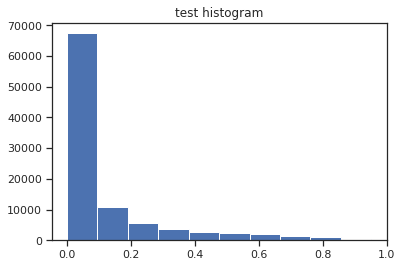

In [22]:
plt.clf()
plt.hist(pred_tests[:, 0])
plt.title('test histogram')
plt.show()